# Library

In [1]:
import os, glob
import yaml
import argparse
from os import path as osp
from datetime import datetime

from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything

from src.models import create_model
from src.data import create_datamodule


In [2]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

ToImage = T.ToPILImage()
ToTensor = T.ToTensor()

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Config

In [4]:
# Config Parser
config_parser = argparse.ArgumentParser()
config_parser.add_argument('-c', '--config', default = 'configs/test/test_clipglean.yaml')
args_config, remaining = config_parser.parse_known_args([])

# Args Parser
parser = argparse.ArgumentParser(description='CLIPGLEAN Demo')
if args_config.config:
    with open(args_config.config, 'r') as f:
        cfg = yaml.safe_load(f)
        parser.set_defaults(**cfg)
args = parser.parse_args(remaining)
args.network['ckpt_path'] = '/data/kka0602/logs/experiments/train/clipglean_v0.3_totalloss_16016__decoder_concat/checkpoint/last.ckpt'
args.scale = 64
args.data['train']['scale'] = args.scale
args.data['test']['scale'] = args.scale
args.network['generator']['in_size'] = 1024 // args.scale



In [5]:
# make directory to save experiment
args.save_path = args.network['save_path'] = osp.join('experiments/demo', args.name)

os.makedirs(args.save_path, exist_ok=True)
os.makedirs(osp.join(args.save_path, 'images'), exist_ok=True)
os.makedirs(osp.join(args.save_path, 'videos'), exist_ok=True)

print(f'Experimental results will be saved at: {args.save_path}')

Experimental results will be saved at: experiments/demo/clipglean_v0.3_cliplossonly_8*8


# Dataloader

In [6]:
# create datamodule
args.data['scale'] = args.scale
args.data['test']['scale'] = args.scale

datamodule = create_datamodule(args.data, is_train=False)
datamodule.setup()

test_loader = datamodule.test_dataloader()

# Model

In [7]:
# create model
with torch.no_grad():
    model = create_model(args.network, is_train=False).cuda()

load checkpoint from http path: http://download.openmmlab.com/mmgen/stylegan2/official_weights/stylegan2-ffhq-config-f-official_20210327_171224-bce9310c.pth


2022-06-13 10:04:12,390 - mmgen - INFO - Load pretrained model from http://download.openmmlab.com/mmgen/stylegan2/official_weights/stylegan2-ffhq-config-f-official_20210327_171224-bce9310c.pth


load checkpoint from http path: http://download.openmmlab.com/mmgen/stylegan2/official_weights/stylegan2-ffhq-config-f-official_20210327_171224-bce9310c.pth


2022-06-13 10:04:15,185 - mmgen - INFO - Load pretrained model from http://download.openmmlab.com/mmgen/stylegan2/official_weights/stylegan2-ffhq-config-f-official_20210327_171224-bce9310c.pth


load checkpoint from torchvision path: torchvision://vgg16
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /data/kka0602/anaconda3/envs/clipglean/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


# Demo

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

In [36]:
idx=32
for batch in test_loader:
    if idx>0:
        idx-=1
        continue
    lq = batch['lq'].cuda()
    gt = batch['gt'].cuda()
    caption = batch['cap']
    break

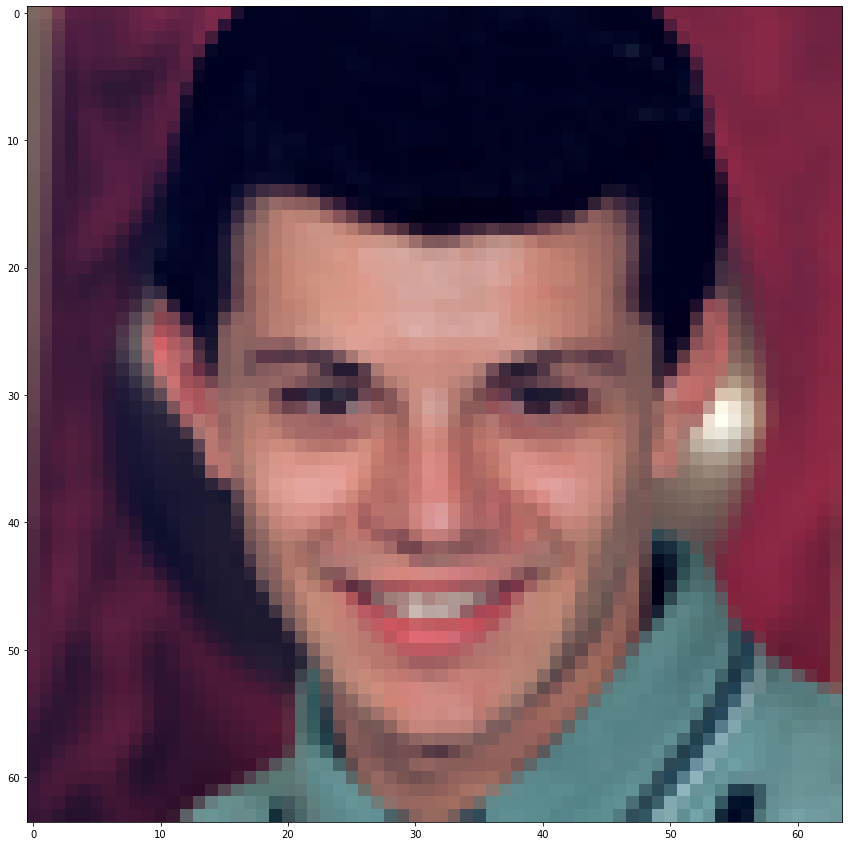

['The person has bags under eyes, black hair, big nose, and mouth slightly open.']

In [39]:
size=64

resized_gt = ToTensor(ToImage(gt[0]/2+0.5).resize((size,size)))#.resize((1024,1024)))
ToImage(resized_gt).save('16x16.png')
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(ToImage(resized_gt))
plt.show()
caption

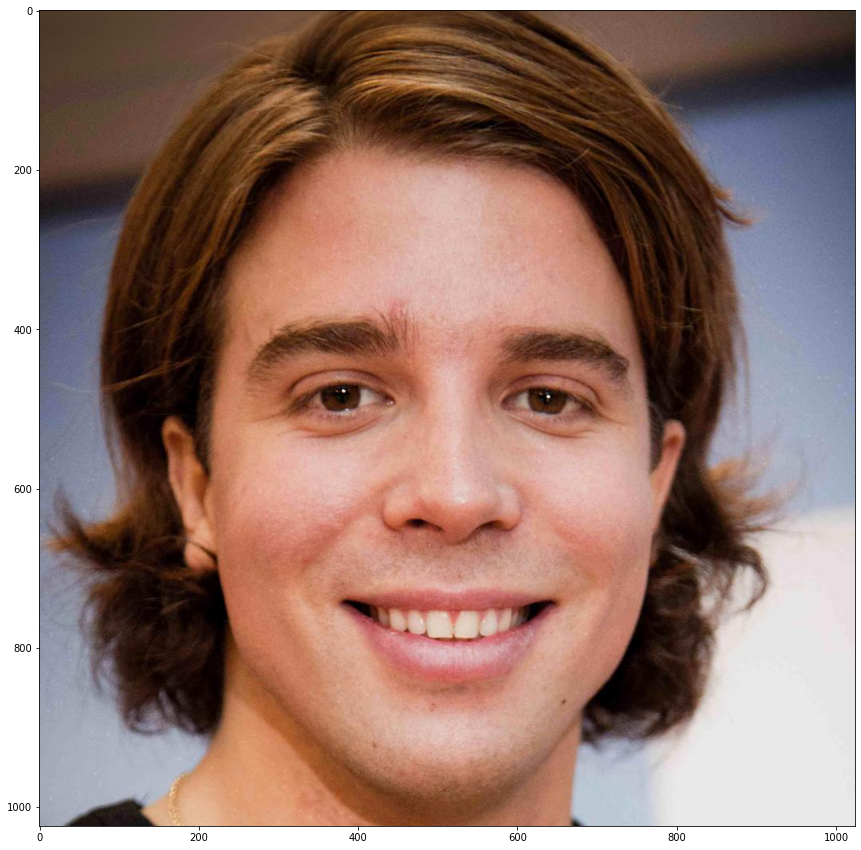

['This person is smiling, and attractive and has mouth slightly open, and bags under eyes.']

In [26]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(ToImage(gt[0]/2+0.5))
plt.show()
caption

# Demo - Compare

In [27]:
def demo(model, lq, caption):
    batch = {}
    batch['lq']=lq.cuda()
    batch['cap']=caption
    with torch.no_grad():
        output = torch.clamp(model(batch)[0], -1, 1)
    return output

def compare_demo_outputs(model, batch, captions):
    lq = batch['lq'].cuda()
    gt = batch['gt'].cuda()
    caption = batch['cap']
    
    fig = plt.figure(figsize=(40,20)) # rows*cols 행렬의 i번째 subplot 생성
    rows = 2
    cols = 4
    n_outputs = rows*cols
    i = 1
    
    # Create output directory
    today = datetime.now()    
    samples_path = os.path.join('./demo/samples', today.strftime('%Y%m%d_%H%M%S'))
    if not os.path.exists(samples_path):
        os.makedirs(samples_path)
        ToImage(gt[0].cpu()).save(os.path.join(samples_path, 'gt.png'))
        
    # plot
    max_caption_len=20
    for i in range(n_outputs):
        output = ToImage(demo(model, lq, captions[i])/2+0.5)
        output.save(os.path.join(samples_path, captions[i][0][:max_caption_len]+'.png'))

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(output)
        ax.set_xlabel(captions[i][0][:max_caption_len], fontsize=30)
        ax.set_xticks([]), ax.set_yticks([]) 


In [28]:
captions = [
    caption,
    ['His mouth is opened. He is smiling'],
    ['She has big mouth. She is laughing'],
    ['He is angry'],
    ['asdfasdf'],
    ['surprised'],
    ['disgusting'],
    ['dirty animal sleeping'],
]

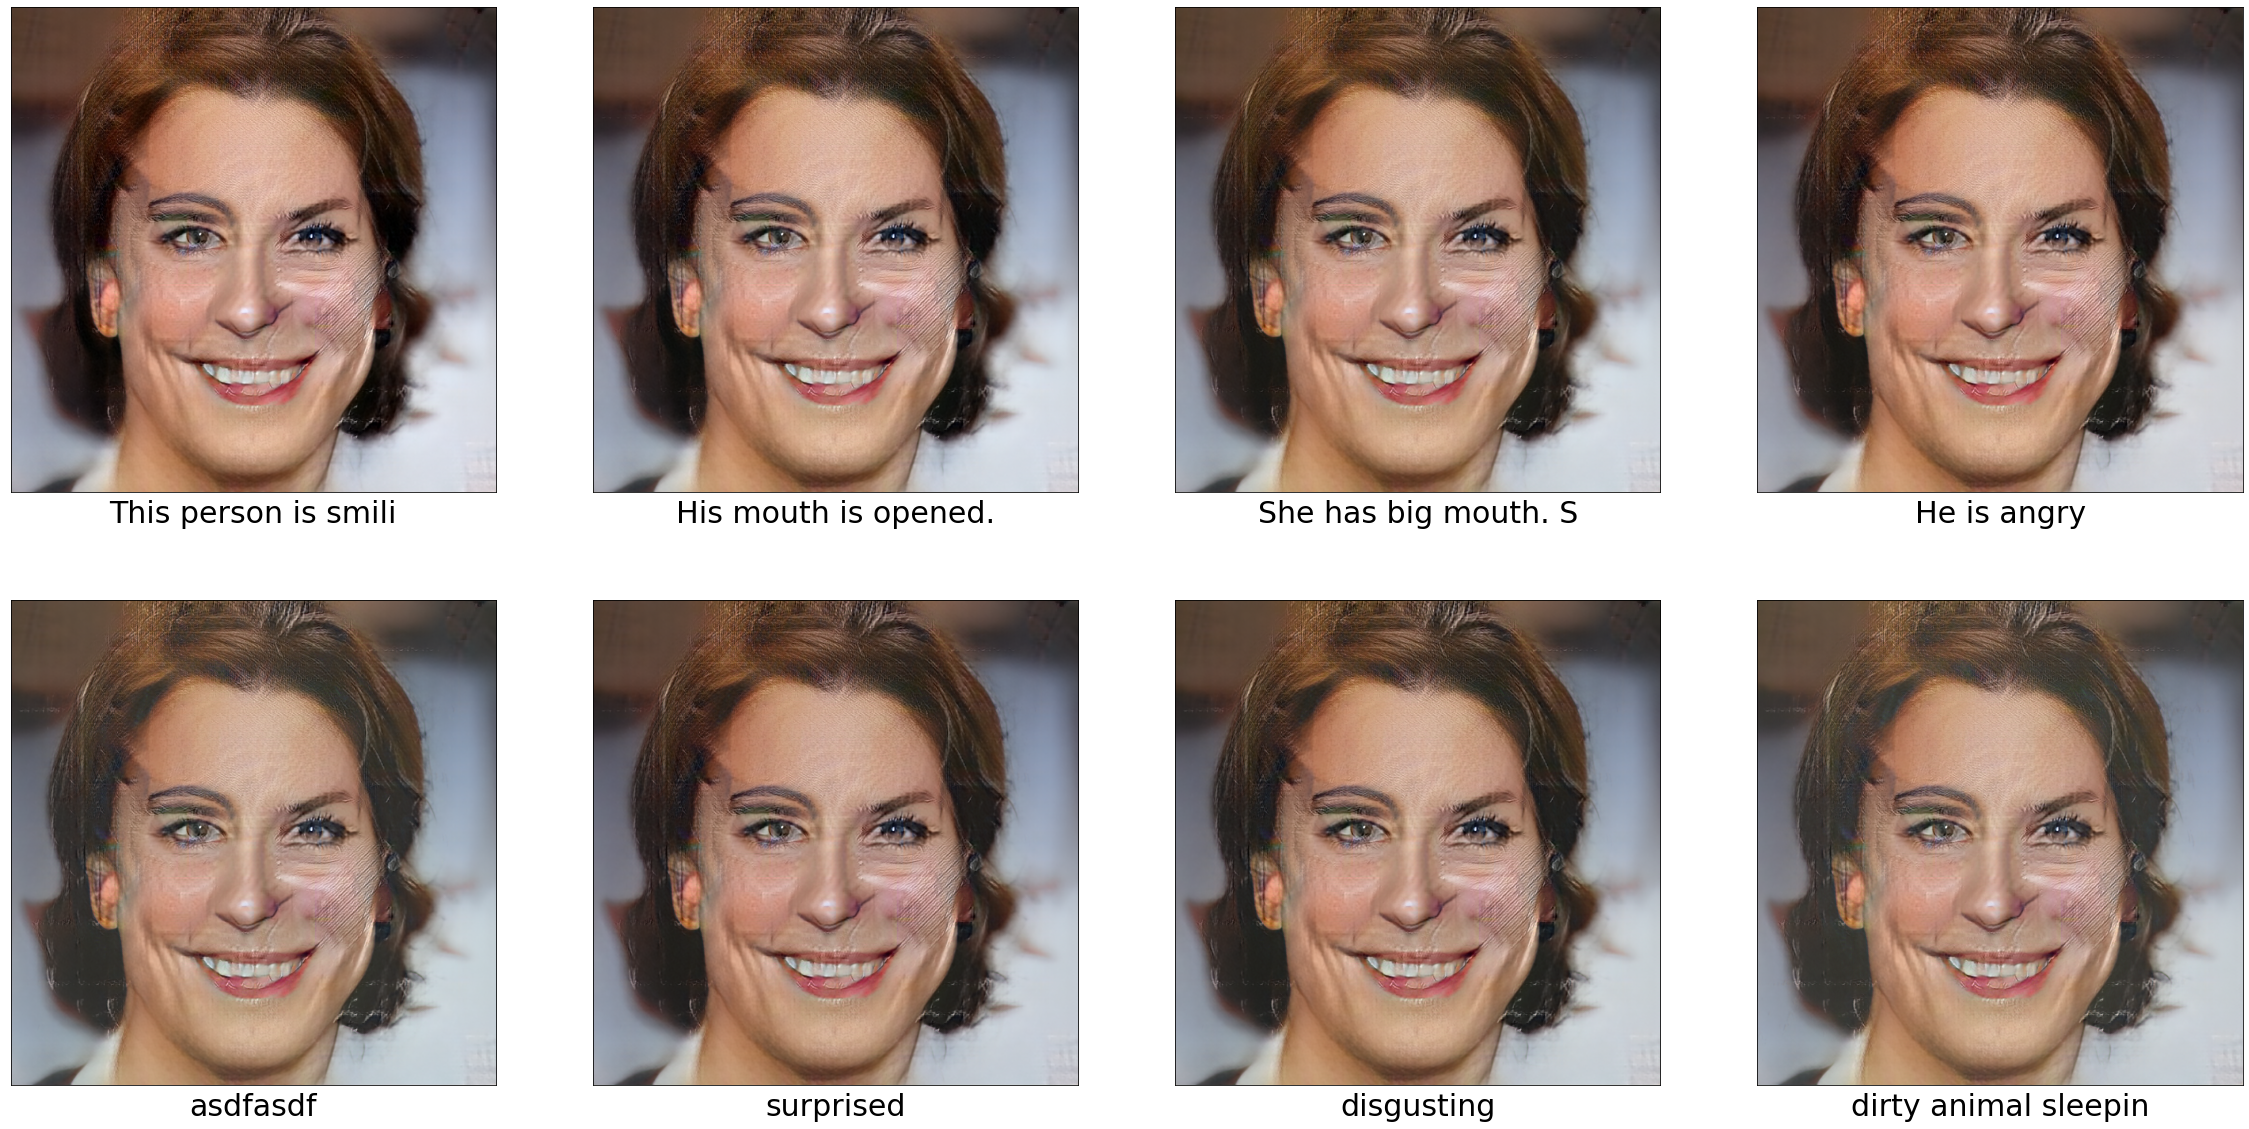

In [29]:
compare_demo_outputs(model, batch, captions)

# Demo - CLIP Latent Space

In [ ]:
import clip

In [ ]:
captions = [
    ['He is black'],
    ['He is white'],
    ['He is happy'],
    ['He is smiling'],
    ['He is wearing white shirts and smiling'],
    ['She is wearing black dress and crying'],
    ['Cat is drinking milk'],
    ['Truck is on the road'],
]


In [ ]:
idx=20
captions0 = []
for batch in test_loader:
    if idx>0:
        idx-=1
        captions0.append(batch['cap'])
        continue
    lq = batch['lq'].cuda()
    gt = batch['gt'].cuda()
    caption = batch['cap']
    break

tokenized_caption = torch.cat([clip.tokenize(cap) for cap in captions0]).cuda()
text_feature0 = model.clip_model.encode_text(tokenized_caption)

In [ ]:
idx=20
captions1 = []
for batch in test_loader:
    if idx>0:
        idx-=1
        captions1.append(batch['cap'])
        continue
    lq = batch['lq'].cuda()
    gt = batch['gt'].cuda()
    caption = batch['cap']
    break

tokenized_caption = torch.cat([clip.tokenize(cap) for cap in captions1]).cuda()
text_feature1 = model.clip_model.encode_text(tokenized_caption)

In [ ]:
captions0

In [ ]:
captions1

In [ ]:
idx0 = 3
idx1 = 3
(text_feature0[idx0] * text_feature1[idx1]).sum()

In [ ]:
text_feature0[0].sum()

# Demo - CLIP Loss

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import torch
import torch.nn as nn
import torchvision.models.vgg as vgg
from mmcv.runner import load_checkpoint
from torch.nn import functional as F
import torchvision
from mmedit.utils import get_root_logger

import clip

class CLIPLoss(nn.Module):
    def __init__(self, model, loss_weight):
        super(CLIPLoss, self).__init__()
        self.model = model
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)
        self.loss_weight = loss_weight

    # TODO check upsample method
    def forward(self, image, text):
        if self.loss_weight <= 0.0: return None

        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity
    

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device="cuda")
cliploss = CLIPLoss(clip_model, 1.0)

In [ ]:
idx=0
for batch in test_loader:
    if idx>0:
        idx-=1
        continue
    lq = batch['lq'].cuda()
    gt = batch['gt'].cuda()
    caption = batch['cap']
    break
caption

In [ ]:
f_norm = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

tokenized_caption = torch.cat([clip.tokenize(cap) for cap in caption]).cuda()
text_features = clip_model.encode_text(tokenized_caption)

loss = cliploss(f_norm(gt), tokenized_caption)
loss

In [ ]:
f_norm = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

tokenized_caption = torch.cat([clip.tokenize('a dog') for cap in caption]).cuda()
text_features = clip_model.encode_text(tokenized_caption)

loss = cliploss(f_norm(gt), tokenized_caption)
loss

# CLIP Loss validity check

In [ ]:
# offical
import torch
import clip
from PIL import Image
model, preprocess = clip.load("ViT-B/32", device=3)

image = preprocess(Image.open("/home/dj_kim/dataset/CelebAHQ/data1024x1024_png/00001.png")).unsqueeze(0).to(3)
text = clip.tokenize(["a woman", "a dog", "a cat", "a man"]).to(3)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs, logits_per_image)  # prints: [[0.9927937  0.00421068 0.00299572]]

In [ ]:
# offical
import torch
import clip
from PIL import Image
model, preprocess = clip.load("ViT-B/32", device=3)

f_norm_1 = torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2))
f_norm_2 = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

image = f_norm_2(f_norm_1(image)).to(3)
text = clip.tokenize(["a woman", "a dog", "a cat", "a man"]).to(3)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs, logits_per_image)  # prints: [[0.9927937  0.00421068 0.00299572]]

In [ ]:
f_norm_1 = torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2))
f_norm_2 = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))


# New CLIPLoss

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import torch
import torch.nn as nn
import torchvision.models.vgg as vgg
from mmcv.runner import load_checkpoint
from torch.nn import functional as F
import torchvision
from mmedit.utils import get_root_logger

import clip

class CLIPLoss(nn.Module):
    def __init__(self, model, loss_weight):
        super(CLIPLoss, self).__init__()
        self.model = model
        self.f_norm_1 = torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2))
        self.f_norm_2 = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)
        self.loss_weight = loss_weight

    # TODO check upsample method
    def forward(self, image, text):
        if self.loss_weight <= 0.0: return None
        
        image = self.f_norm_1(image)
        image = self.f_norm_2(image)
        print(image.shape)
        image = self.avg_pool(self.upsample(image))
        print(image.shape)
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity
    

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device="cuda")
cliploss = CLIPLoss(clip_model, 1.0)

In [ ]:
idx=4
for batch in test_loader:
    if idx>0:
        idx-=1
        continue
#     lq = batch['lq'].cuda()
#     gt = batch['gt'].cuda()
    caption = batch['cap']
    break

In [ ]:
caption

In [ ]:
tokenized_caption = torch.cat([clip.tokenize(cap) for cap in caption]).cuda()
text_features = clip_model.encode_text(tokenized_caption)

loss = cliploss(gt, tokenized_caption)
loss = -(loss-1)*100
loss / 100

In [ ]:
tokenized_caption = torch.cat([clip.tokenize(cap) for cap in caption]).cuda()
text_features = clip_model.encode_text(tokenized_caption)

loss = cliploss(gt, tokenized_caption)
loss = -(loss-1)*100
loss / 100

In [ ]:
torch.nn.Softmax()(torch.Tensor([25,18,18,18]))

# Playground

In [ ]:

torch.exp(torch.Tensor([0.8]))